<a href="https://colab.research.google.com/github/bodhivani/RAVEfold/blob/main/heavydemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RaveFold colab demo (heavy)

This colab is intended to demonstrate in detail the code used in [Vani, Aranganathan et al.](https://doi.org/10.1101/2022.05.25.493365), **"AlphaFold2-RAVE: From sequence to Boltzmann ensemble"**. We use the cold-shock protein as our tutorial system.

This can be used as a step-by-step runthrough of the entire protocol, and to make this feasible, we have chosen hyperparameters that allow for fast simulations. For robustness, these should be increased as noted.



# ColabFold (altered for stochasticity)

In [ ]:
#@title Install ColabFold
# setup device
from IPython.display import clear_output
!mkdir struct_gen
%cd /content/struct_gen/.
clear_output()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook


install_jackhmmer = True      #not required

#AF2 repo from deepmind
GIT_REPO = 'https://github.com/deepmind/alphafold'
#AF2 params
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'

PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

#tqdm specification
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code and clone colabfold repo
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone https://github.com/sokrypton/ColabFold.git")

    # apply patches
    os.system(f"patch -u alphafold/alphafold/model/model.py -i ColabFold/beta/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/mapping.py -i ColabFold/beta/mapping.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i ColabFold/beta/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/folding.py -i ColabFold/beta/folding.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i ColabFold/beta/config.patch")
    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i ColabFold/beta/protein.patch")
    pbar.update(4)

    #install biopython
    os.system(f"pip install biopython dm-haiku==0.0.5 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer   #not required and will remove it
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

###############################################################################################
####    Python imports 
###############################################################################################
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

!cd ..

Running on GPU


  0%|          | 0/55 [elapsed: 00:00 remaining: ?]

In [ ]:
#@title Run Colabfold with reduced MSA
#Code was taken from COLABFOLD git and modified for convenience 
import re
import time
from IPython.display import clear_output

%cd /content/struct_gen/.
#####################################################################################################################
###    Input sequence
#####################################################################################################################

#@markdown Change this to the amino acid sequence of your system
sequence = 'MQRGKVKWFNNEKGYGFIEVEGGSDVFVHFTAIQGEGFKTLEEGQEVSFEIVQGNRGPQAANVVKE' #@param {type:"string"}
jobname = "CSP" #@param {type:"string"}
homooligomer =  "1" #param {type:"string"}


#####################################################################################################################
###    MSA parameters
#####################################################################################################################

add_custom_msa = False 
msa_format = "fas" 
pair_mode = "unpaired" 
pair_cov = 50 
pair_qid = 20 

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)
msa_method = "mmseqs2" 
#I['output_dir']='_'.join(I['output_dir'].split('_')[:-1])
I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I
clear_output() # ----> Clear the output from previous functions
#No relaxation 
num_relax = "None"


#####################################################################################################################
###    Parameters for running Alphafold
#####################################################################################################################
rank_by = "pLDDT" 
use_turbo = True 
#@markdown This parameter can be "tuned". Too low, and it doesn't have enough information for sensible predictions. Too high, and it will not generate structural diversity
max_msa = "08:16" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64","16:32","08:16","04:08","02:04","01:02","02:02"]
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. 
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

show_images = False 

num_models = 5 
use_ptm = True 
num_ensemble = 1 
max_recycles = 1 
is_training = True 
num_samples = 128 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
#@markdown - `num_samples` defines the number of random seed. (For each seed 5 different models are predicted)  
subsample_msa = True 

if not use_ptm and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# prep input features
feature_dict = cf_af.prep_feats(mod_I, clean=IN_COLAB)
Ls_plot = feature_dict["Ls"]

# prep model options
opt = {"N":len(feature_dict["msa"]),
       "L":len(feature_dict["residue_index"]),
       "use_ptm":use_ptm,
       "use_turbo":use_turbo,
       "max_recycles":max_recycles,
       "tol":0.0,
       "num_ensemble":num_ensemble,
       "max_msa_clusters":max_msa_clusters,
       "max_extra_msa":max_extra_msa,
       "is_training":is_training}

if use_turbo:
  if "runner" in dir():
    # only recompile if options changed
    runner = cf_af.prep_model_runner(opt, old_runner=runner)
  else:
    runner = cf_af.prep_model_runner(opt)
else:
  runner = None

#####################################################################################################################
###    Run Alphafold with low MSA 
#####################################################################################################################
t1 = time.perf_counter()
outs, model_rank = cf_af.run_alphafold(feature_dict, opt, runner, num_models, num_samples, subsample_msa,
                                       rank_by=rank_by, show_images=show_images)



#####################################################################################################################
###    Output folder
#####################################################################################################################

structures_path='/content/Structures'   #Output_folder
os.makedirs(structures_path)
file_path=os.path.join(structures_path,'file_details.txt')
with open(file_path, "w") as file_details:
  for n,key in enumerate(model_rank):
    copy_line=f'cp {I["output_dir"]}/rank_{n+1}_{key}_unrelaxed.pdb {structures_path}/pred_{n+1}.pdb'
    os.system(copy_line)
    if num_relax !="None":
      if n<num_relax: 
        copy_line2=f'cp {I["output_dir"]}/rank_{n+1}_{key}_relaxed.pdb {structures_path}/pred_{n+1}.pdb'
        os.system(copy_line2)
    line = f"pred_{n+1}.pdb pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    file_details.write(line+"\n")

#os.system(f'rm -r {I[output_dir]}')   #--> run this line to delete the second copy of structures
%cd /content/
os.system(f'zip -FSr Structures.zip {structures_path}')
t2 = time.perf_counter()
clear_output()
print('\nTime taken to generate:',(t2-t1)/60,' mins')

print(f'The structures can be found in {structures_path}')

  0%|          | 0/640 [elapsed: 00:00 remaining: ?]

# Installations for molecular dynamics

In [2]:
#@title Install condacolab
#@markdown After running this cell wait for the kernel to restart (~1min)

#@markdown Then, start running the rest of the blocks
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [1]:
#@title Install OpenMM with Plumed
#@markdown Run this to install and import libraries 
import time
t1 = time.perf_counter()
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    #!conda install -qy conda==4.13.0
    !conda install -q -y -c conda-forge openmm cudatoolkit=11.2 openmmforcefields openmm-plumed pdbfixer mdtraj
    !conda install -qy pytorch==1.8.0 -c pytorch -c nvidia
    on_colab = True
    clear_output()             # clear the excessive installation outputs (disable incase of error check)
    print("Dependencies successfully installed and imported!")
except ModuleNotFoundError:
    on_colab = False


# required for simulation with Plumed on gpu
from sys import stdout
from openmmplumed import PlumedForce
from openmm.app import *
from openmm import *
from openmm.unit import *
import pdbfixer

# required for analysis
import numpy as np
import matplotlib.pyplot as plt

t2 = time.perf_counter()
print(f'time taken to run:{(t2-t1)/60:.2f} mins')

#create the directory for colabfold


Dependencies successfully installed and imported!


time taken to run:11.68 mins


# Setup initial files

In [3]:
#@title Import other requirements

import numpy as np
import os
import time
import matplotlib.pyplot as plt

!rm -r RAVEfold 
!git clone https://github.com/bodhivani/RAVEfold

!cp RAVEfold/ravefuncs.py .
import ravefuncs as rave
import importlib
importlib.reload(rave)

!git clone https://github.com/tiwarylab/State-Predictive-Information-Bottleneck
%rm -r State-Predictive-Information-Bottleneck/examples

Cloning into 'RAVEfold'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 221 (delta 56), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (221/221), 6.57 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (112/112), done.


fatal: destination path 'State-Predictive-Information-Bottleneck' already exists and is not an empty directory.
rm: cannot remove 'State-Predictive-Information-Bottleneck/examples': No such file or directory


In [6]:
#@title Analysis on AF2 structures
if os.path.isdir("Structures")==False:
  os.system("unzip RAVEfold/CSP_data/structures.zip -d .")
  num_samples=128

tot=num_samples*5
os.chdir("Structures")
os.system('cp ../RAVEfold/CSP_data/plumed_AF2.dat .')
inputline=' '.join([f'pred_{i+1}.pdb' for i in range(tot)])
os.system(f'mdconvert {inputline} -o AF2samples.xtc')
os.system('plumed driver --plumed plumed_AF2.dat --ixtc AF2samples.xtc')
os.chdir("..")

In [7]:
#@title Cluster to initialize RAVEfold
CVs=np.loadtxt("Structures/COLVARS_AF2.dat")[:,1:]
centers,listindices=rave.RegSpaceClustering(CVs,6.5,max_centers=10, batch_size=50) #change to 5 or 5.5 for robustness
t_af2=rave.getTrp8(CVs)
t_cluster=rave.getTrp8(centers.T)

Found 3 centers!


# RAVEfold

In [8]:
#@title Unbiased simulations
t1 = time.perf_counter()
if os.path.isdir("Structures")==False:
  os.system("unzip RAVEfold/CSP_data/structures.zip -d .")
  num_samples=128
  listindices=[1, 224, 627, 533]
  
#@markdown Check the below box to run on GPU
on_gpu=True #@param {type:"boolean"}
#@markdown MD parameters

#@markdown Integration Timestep (ps)
dt =0.004 #@param{type:"number"}
#@markdown Temperature (K)
temp=300 #@param{type:"number"}
freq=1 #param{type:"number"}
#@markdown Number of steps 
nstep=40000 #@param{type:"number"}
#markdown Plumed file
plumedfile="plumed_unb.dat" #param{type:"string"}

os.mkdir("unbiased")
os.chdir("./unbiased")
cpath=os.getcwd()
os.system('cp /content/RAVEfold/CSP_data/plumed_unb.dat .')
plumedfile=os.path.join(cpath,plumedfile)
for index in listindices:
  os.mkdir(f'{index}')
  os.chdir(f'./{index}')
  os.system(f"cp /content/Structures/pred_{index}.pdb .")
  rave.run_unbiased(on_gpu,plumedfile,dt,temp,freq,nstep,index)
  os.chdir("..")

os.chdir("..")
t2 = time.perf_counter()
print(f'time taken to run:{(t2-t1)/60:.2f} mins')

We are at /content/unbiased/1
We are at /content/unbiased/366
We are at /content/unbiased/627
time taken to run:3.01 mins


In [52]:
#@title SPIB on unbiased simulations
%cd /content/
if os.path.isdir("SPIB_unbiased"):
  os.system("rm -r SPIB_unbiased")
cvs=[]
os.mkdir("SPIB_unbiased")
os.chdir("SPIB_unbiased")
num_state=len(listindices)*2
for i,index in enumerate(listindices):
    cvs.append(np.loadtxt("../unbiased/%i/COLVAR_unb.dat"%index)[:,1:])
    np.save("colvar_%i_unb.npy"%i,cvs[i])
    lentraj=len(cvs[i])
    zeroone=np.hstack([np.zeros(int(lentraj/2),dtype=np.int8),np.ones(lentraj-int(lentraj/2),dtype=np.int8)])
    initlabels=np.eye(num_state)[zeroone+int(i*2)]
    np.save("labels_%i_unb.npy"%i,initlabels)

dt=2


f_nodt=open('../RAVEfold/sample_config.ini')
f=open('config.ini','w')
lines=f_nodt.readlines()
lines.insert(2,f'dt =[{dt}]\n')
f.writelines(lines)
f_nodt.close()

unbpath="unbiased"

f.write("\n traj_data = [%s]\n"%",".join(["%s/colvar_%i_unb.npy"%(unbpath,i) for i in range(len(cvs))]))

f.write("\n initial_labels = [%s]\n"%",".join(["%s/labels_%i_unb.npy"%(unbpath,i) for i in range(len(cvs))]))

f.write("\n traj_weights \n")

f.close()

os.chdir("..")
%mv SPIB_unbiased State-Predictive-Information-Bottleneck/unbiased

/content


In [53]:
%cd /content/State-Predictive-Information-Bottleneck/
%run test_model_advanced.py -config unbiased/config.ini

/content/State-Predictive-Information-Bottleneck
tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.811608
Update lr to 0.010000
Epoch: 1

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.000000
Update lr to 0.010000
Epoch: 2

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.000000
Update lr to 0.010000
Epoch: 3

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.000000
Update lr to 0.010000
Update 1

Epoch: 0

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.000000
Update lr to 0.010000
Epoch: 1

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.000000
Update lr to 0.010000
Epoch: 2

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population change=0.000000
Update lr to 0.010000
Update 2

Epoch: 0

tensor([0.1313, 0.0000, 0.0000, 0.0000, 0.8687, 0.0000])
State population cha

/usr/local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [82]:
prefix='SPIB/Unweighted_d=2_t=%i_b=0.0100_learn=0.010000_'%dt
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
lspace=[np.load(prefix+"traj%i_mean_representation0.npy"%i) for i in range(len(cvs))]
lstacked=np.vstack([np.hstack([lspace[j][:,i] for j in range(len(cvs))]) for i in range(2)])
width1=np.std(lstacked[0])/5
width2=np.std(lstacked[1])/5
gridmin1=lstacked[0].min()*10
gridmax1=lstacked[0].max()*10
gridmin2=lstacked[1].min()*10
gridmax2=lstacked[1].max()*10

In [110]:
#@title Biased simulations

#@markdown Here we are using already solvated and equilibrated system(from GMX)

# Inputs definition 

#@markdown metadynamics parameters
height = 1.5 #@param{type:"number"}
biasfactor=10 #@param{type:"number"}
#@markdown Length of metadynamics simulation


os.chdir("/content/")
!cp RAVEfold/CSP_data/plumed_unb.dat plumed_unb.dat
colvar="sc1_r1,cc1_r1,sc1_r2,cc1_r2,sc1_r3,cc1_r3,sc1_r5,cc1_r5,sc1_r6,cc1_r6,sc1_r7,cc1_r7,sc1_r8,cc1_r8,sc1_r9,cc1_r9,sc1_r10,cc1_r10,sc1_r11,cc1_r11,sc1_r12,cc1_r12,sc1_r13,cc1_r13,sc1_r15,cc1_r15,sc1_r17,cc1_r17,sc1_r18,cc1_r18,sc1_r19,cc1_r19,sc1_r20,cc1_r20,sc1_r21,cc1_r21,sc1_r24,cc1_r24,sc1_r25,cc1_r25,sc1_r26,cc1_r26,sc1_r27,cc1_r27,sc1_r28,cc1_r28,sc1_r29,cc1_r29,sc1_r30,cc1_r30,sc1_r31,cc1_r31,sc1_r33,cc1_r33,sc1_r34,cc1_r34,sc1_r36,cc1_r36,sc1_r38,cc1_r38,sc1_r39,cc1_r39,sc1_r40,cc1_r40,sc1_r41,cc1_r41,sc1_r42,cc1_r42,sc1_r43,cc1_r43,sc1_r45,cc1_r45,sc1_r46,cc1_r46,sc1_r47,cc1_r47,sc1_r48,cc1_r48,sc1_r49,cc1_r49,sc1_r50,cc1_r50,sc1_r51,cc1_r51,sc1_r52,cc1_r52,sc1_r53,cc1_r53,sc1_r55,cc1_r55,sc1_r56,cc1_r56,sc1_r58,cc1_r58,sc1_r59,cc1_r59,sc1_r62,cc1_r62,sc1_r63,cc1_r63,sc1_r64,cc1_r64,sc1_r65,cc1_r65,sc1_r66,cc1_r66,sc2_r1,cc2_r1,sc2_r2,cc2_r2,sc2_r3,cc2_r3,sc2_r5,cc2_r5,sc2_r7,cc2_r7,sc2_r8,cc2_r8,sc2_r9,cc2_r9,sc2_r10,cc2_r10,sc2_r11,cc2_r11,sc2_r12,cc2_r12,sc2_r13,cc2_r13,sc2_r15,cc2_r15,sc2_r17,cc2_r17,sc2_r18,cc2_r18,sc2_r19,cc2_r19,sc2_r21,cc2_r21,sc2_r25,cc2_r25,sc2_r27,cc2_r27,sc2_r29,cc2_r29,sc2_r30,cc2_r30,sc2_r33,cc2_r33,sc2_r34,cc2_r34,sc2_r36,cc2_r36,sc2_r38,cc2_r38,sc2_r39,cc2_r39,sc2_r41,cc2_r41,sc2_r42,cc2_r42,sc2_r43,cc2_r43,sc2_r45,cc2_r45,sc2_r46,cc2_r46,sc2_r49,cc2_r49,sc2_r50,cc2_r50,sc2_r51,cc2_r51,sc2_r53,cc2_r53,sc2_r55,cc2_r55,sc2_r56,cc2_r56,sc2_r58,cc2_r58,sc2_r59,cc2_r59,sc2_r62,cc2_r62,sc2_r65,cc2_r65,sc2_r66,cc2_r66,sc3_r1,cc3_r1,sc3_r2,cc3_r2,sc3_r3,cc3_r3,sc3_r5,cc3_r5,sc3_r7,cc3_r7,sc3_r12,cc3_r12,sc3_r13,cc3_r13,sc3_r19,cc3_r19,sc3_r21,cc3_r21,sc3_r34,cc3_r34,sc3_r36,cc3_r36,sc3_r39,cc3_r39,sc3_r42,cc3_r42,sc3_r43,cc3_r43,sc3_r45,cc3_r45,sc3_r46,cc3_r46,sc3_r50,cc3_r50,sc3_r53,cc3_r53,sc3_r56,cc3_r56,sc3_r59,cc3_r59,sc3_r65,cc3_r65,sc3_r66,cc3_r66,sc4_r3,cc4_r3,sc4_r5,cc4_r5,sc4_r7,cc4_r7,sc4_r13,cc4_r13,sc4_r39,cc4_r39,sc4_r56,cc4_r56,sc4_r65,cc4_r65,sc5_r3,cc5_r3,sc5_r56,cc5_r56"
plumedfile="plumed_unb.dat"
rave.make_biased_plumed(plumedfile,weights,colvar,height,biasfactor,width1,width2,gridmin1,gridmin2,gridmax1,gridmax2)

pdbfile="Structures/pred_1.pdb"

0.011947204,-0.005905227,-0.029755214,0.013435132,0.025653787,-0.04375178,-0.0077573853,0.016567964,0.06122533,-0.05093907,0.055826694,-0.006122062,0.014070602,-0.054567635,-0.055632725,-0.0323822,-0.0046589775,0.012026942,0.056562204,-0.010465158,0.04359695,-0.053053547,0.035410155,-0.05466757,-0.060028598,0.037956227,-0.041284356,-0.03495618,-0.037349723,-0.017462935,0.030884353,0.03165885,-0.04760702,0.0050983694,-0.05230086,-0.05369921,-0.016154712,-0.005430369,0.03155533,0.02745531,0.015775831,0.048253626,-0.007243797,-0.005611505,0.06112084,0.0043309657,0.04306712,-0.03151735,0.040572178,0.037789162,0.049744442,-0.037502646,-0.06033274,0.011210335,-0.00803912,0.05985768,-0.021134041,-0.02771251,0.009870982,-0.05052399,-0.051971264,0.04072309,0.014449091,0.012456276,-0.009644828,0.035292756,-0.023854246,0.019191854,0.021102617,0.01607603,-0.043195873,-0.05857626,-0.030154986,-0.053989675,-0.05481069,-0.021836966,-0.0066936202,0.009335499,-0.032636613,-0.04069346,-0.016711244,0.036

In [3]:
%cd /content/unbiased/1/
%cp plumed_biased.dat plumed_biasd_1.dat

/content/unbiased/1


In [6]:
#%cd /content/unbiased/1/
#%cp /content/plumed_biased.dat .
on_gpu=True
dt=0.004
temp=300 
nstep=40000
listindices=[1,222]
freq=1
rave.run_biased(on_gpu,'plumed_biasd_1.dat',dt,temp,freq,nstep,listindices[0])

add sys
assigned integrator
assigning gpu
done assigning GPU
before run


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'LineWidth'
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, '$\\chi_2$ (radians)')

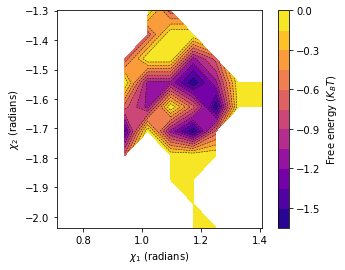

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plumedfile=np.loadtxt("COLVAR_biased.dat")[:,1:]
CVs_metad=plumedfile[:,:250]

w=np.exp(plumedfile[:,-1])

t_af2=rave.getTrp8(CVs_metad)

H,xlims,ylims=np.histogram2d(t_af2[0],t_af2[1],bins=10)
xlims=(xlims[1:]+xlims[:-1])/2
ylims=(ylims[1:]+ylims[:-1])/2
plt.contourf(xlims,ylims,-np.log(H).T,"-w",levels=10,cmap="plasma",LineWidth=1)
cbar=plt.colorbar()
cbar.set_label("Free energy $(K_BT)$")
plt.contour(xlims,ylims,-np.log(H).T,colors="black",levels=10,linewidths=0.5)
plt.gca().set_aspect('equal')
plt.xlabel("$\chi_1$ (radians)")
plt.ylabel("$\chi_2$ (radians)")


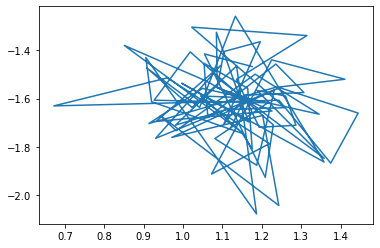

In [19]:
plt.plot(t_af2[0],t_af2[1])